In [10]:
# use SAM model to segment the image

import os
import pickle
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import (
    SamAutomaticMaskGenerator, sam_model_registry,
    SamPredictor
)

from utils import show_mask, show_box

# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
device = "mps"

sam_checkpoint = "/Users/naman/Workspace/Code/Python/BM5020-Project/sam_vit_h_4b8939.pth"
# sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

In [8]:
im_dir = "/Users/naman/Workspace/Data/BM5020-POEM/Annotated"
im_paths = [f"{im_dir}/{im_file}" for im_file in os.listdir(im_dir)]

path_iter = iter(im_paths)

In [65]:
all_masks = {}

---

M_01092024123848_20698524_1_001_0001-01.MP4-frame23206.jpg


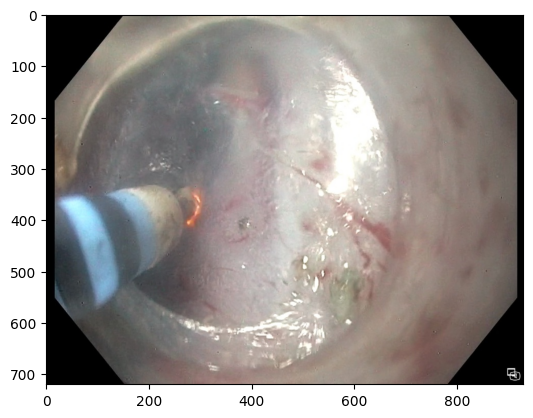

In [200]:
im_path = next(path_iter)
filename = os.path.split(im_path)[1]
while os.path.splitext(im_path)[1] != ".jpg" and filename not in all_masks.keys():
    im_path = next(path_iter)

print(filename)
image = cv2.imread(im_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
plt.imshow(image)
plt.show()

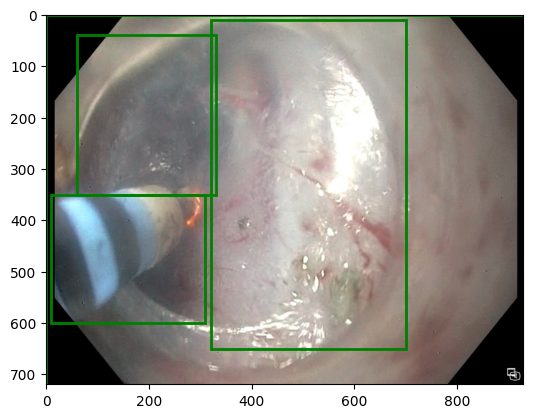

In [209]:
input_boxes = torch.tensor([

    # 0 - Background (Null class)
    [0, 0, *image.shape[-2::-1]],

    # 1 - Muscle layer
    [320, 10, 700, 650],

    # 2 - Mucosal layer
    [60, 40, 330, 350],

    # 3 - Electrode
    [10, 350, 310, 600]

]).to(device)

plt.imshow(image)
for box in input_boxes:
    show_box(box.cpu(), plt.gca())
plt.show()

In [210]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

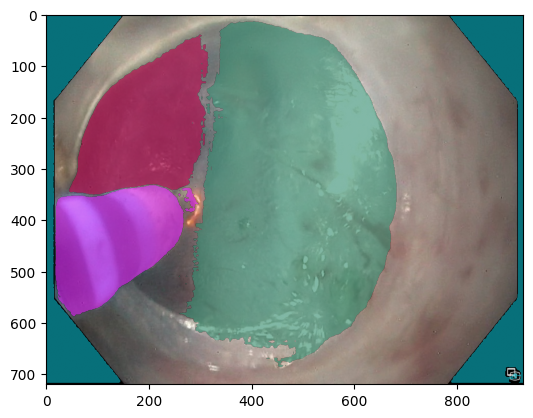

In [211]:
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.show()

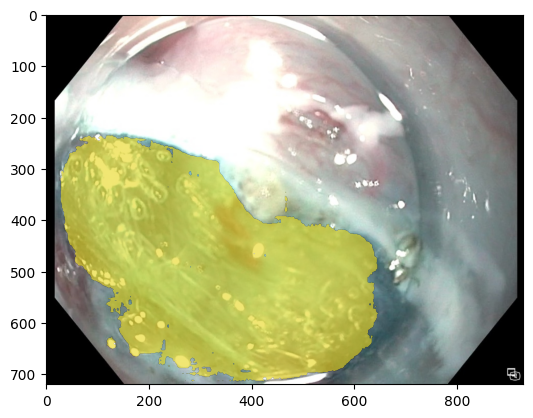

In [198]:
show_ind = 2
plt.imshow(image)
show_mask(masks[show_ind].cpu().numpy(), plt.gca(), random_color=True)
plt.show()

In [212]:
all_masks[filename] = masks.squeeze().argmax(0).cpu()

---

In [215]:
masks.squeeze().shape

torch.Size([4, 720, 930])

In [217]:
with open(f"{im_dir}/annotations.pkl", "wb") as fp:
    pickle.dump(all_masks, fp)

In [29]:
image = cv2.imread("img.jpg")
image = image[:, 380:, :]

# image = cv2.imread("tiger.jpg")

In [30]:
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

26
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [31]:
segments = []
for mask in masks:
    segments.append(mask['segmentation'])

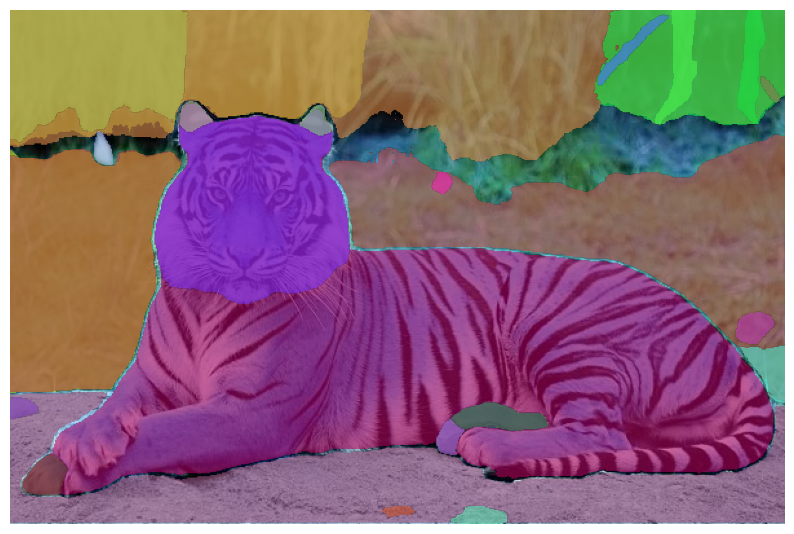

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in segments:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show() 